In [1]:
import importlib
import math
import argparse
import sys
import time
import traceback
import json
from pubsub import pub
pub.unsubAll()
import schedula as sh
import numpy as np
import cv2

import VODEvents
from ImgProc import ImgTask
import RangeStats

import video
importlib.reload(video)

<module 'video' from 'D:\\working\\video\\video.py'>

In [2]:
argp = argparse.ArgumentParser(description='VOD review tool')
argp.add_argument('source', nargs='?', default='test.mkv', 
                help='video source path')
argp.add_argument('--skip', type=int, nargs='?', default=190,
                help='start at offset frames into video')
argp.add_argument('-m', '--manual', action='store_false',
                help='turn off autoplay')
argp.add_argument('-d', '--dump', nargs='?', const='dump.mp4', default=None,
                help='dump out debug frame to video file')
params = argp.parse_args('test.mkv'.split(' '))

In [3]:
cap = cv2.VideoCapture(params.source)
if not cap.isOpened():
    print ('error opening')

SKIP_FRAMES = params.skip # skip VOD preamble
PAUSE = False
# 23-09-15 tricky bot appear: 1440, 2590
# 23-12-24 tricky bot appear: 811, 1433
cap.set(cv2.CAP_PROP_POS_FRAMES, SKIP_FRAMES-1)
frame_num = SKIP_FRAMES-1
ret, frame = cap.read()
ydim, xdim, depth = frame.shape
midx = xdim//2
midy = ydim//2
frate = cap.get(cv2.CAP_PROP_FPS)
frames_total = int(cap.get( cv2.CAP_PROP_FRAME_COUNT))
print ('Video = %s @ %s fps. %s frames'%(frame.shape,frate, frames_total))

show_img = 0
autoplay = params.manual
if not video.BATCH:
    def breakpoint(timestamp=0, x=0, y=0):
        global autoplay
        autoplay = False
    #pub.subscribe(breakpoint, VODEvents.BOT_APPEAR) # pause at certain events
    #pub.subscribe(breakpoint, VODEvents.KEY_ANY_DOWN) # pause at certain events
else:
    autoplay = True

DUMP_DBG = params.dump
vidout = None
if DUMP_DBG is not None:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    vidout = cv2.VideoWriter(DUMP_DBG, fourcc, frate, (xdim, ydim))

Video = (1080, 1920, 3) @ 60.0 fps. 2955 frames


In [4]:
pub.subscribe(video.dbg_event, pub.ALL_TOPICS)
pub.sendMessage(VODEvents.VOD_START, 
                pipe= ImgTask.pipe,
                width= xdim,
                height= ydim,
                depth= depth,
                frame_rate= frate,) # initialize all modules

ImgTask.pipe.add_capture(ImgTask.IMG_DEBUG)
ImgTask.pipe.add_capture(VODEvents.EVENT_NODE)

event VSTART / {'pipe': <ImgProc.ImgTask.ImgPipe object at 0x0000017EE4B8EE90>, 'width': 1920, 'height': 1080, 'depth': 3, 'frame_rate': 60.0}


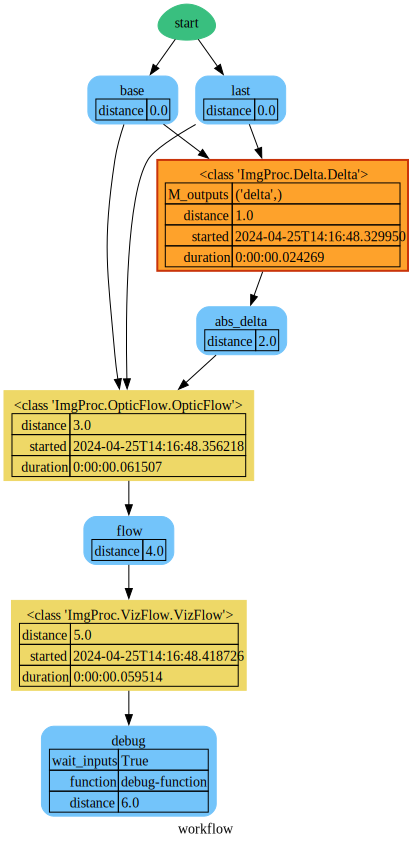

In [9]:
plt = ImgTask.pipe.dsp.plot(view=False, engine='dot', body={'style': 'filled', 'ordering':'out'}, workflow=True)
display(plt)

In [ ]:
total=0
for k,v in ImgTask.pipe.dsp.solution.workflow.nodes.items():
    if 'duration' in v:
        dur = v['duration']*1000
        total += dur
        print ('%s : %s'%(k, dur))
print ('total= %s'%(total))

In [8]:
if not (cap.isOpened()):
    print ('cap is not opened')
    exit()

if not PAUSE:
    lframe = frame
    ret, frame = cap.read()
else:
    PAUSE = False
if not ret: # out of frames, VOD done
    exit()
frame_num += 1
print (frame_num)

outs = [#RangeStats.NODE, 
        ImgTask.IMG_DEBUG]
tst = time.time_ns()
sol = ImgTask.pipe.run_pipe(ins={'base': frame, 
                            'last': lframe,
                            'frame_num': frame_num,
                            'timestamp': int(frame_num*1000/frate),
                            }, outs=outs)
ten = time.time_ns()
print ('pipe= %3.3fms'%((ten-tst)/1e6))

191
pipe= 151.299ms


In [ ]:
print (ImgTask.pipe.sol['debug'])

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

k1 = [*sol['debug']][2]
outimg = sol['debug'][k1]
outimg = cv2.cvtColor(outimg, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(outimg)
plt.show()

In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

k1 = [*sol['debug']][1]
outimg = sol['debug'][k1]
outimg = cv2.cvtColor(outimg, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.figure(figsize=(30, 20))
plt.axis('off')
plt.imshow(outimg)
plt.show()

In [ ]:
aug_shape = (frame.shape[0], frame.shape[0], 2)
y = np.zeros(aug_shape)
y.shape

In [ ]:
dsp = sh.Dispatcher(name='test')

def my_function(a,b):
    c=a+b
    d=a-b
    return c,d

def hole(a):
    print (a)
    return []

def hole2(a):
    print(a)

def collate(kwargs):
    return kwargs

dsp.add_data(data_id='g', wait_inputs=True, function=collate)
dsp.add_function(function=my_function, inputs=['a1', 'b1'],
                 outputs=['c', 'd'])
dsp.add_function(function=lambda x,y: x*10+y*100, inputs=['c', 'd'],
                 outputs=['e'])
dsp.add_function(function=lambda x,y: x*10+y*100, inputs=['a1', 'b1'],
                 outputs=['f'])
dsp.add_function(function=hole, inputs=['f'],
                 outputs=['g'])
dsp.add_function(function=hole2, inputs=['e'],
                 outputs=['g'])
dsp.add_function(function=collate, inputs=['g'],
                 outputs=['h'])
#dsp.add_data(data_id='g')

In [ ]:
outs = ['g']
sol = dsp.dispatch({'a1': np.array([[5,2,3,1],[1,2,3,4]]), 'b1': 3}, outputs=outs, executor='async')
print (sol)
sol2 = sol.result()
print (sol2)
res = {k:sol[k] for k in outs}
print (res)
print (res['g'])

In [ ]:
# Click on the graph to see the model.
x = dsp.plot(view=False, engine='dot', body={'style': 'filled'}, workflow=True)

In [ ]:
display(x)